## Input feature range approximation based on sensitivity analysis of the model


In [ ]:
import numpy as np
import optuna
from sklearn.datasets import make_regression
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats


X, y = make_regression(n_samples=1000, n_features=1, noise=0.1, random_state=42)
model = MLPRegressor(hidden_layer_sizes=(64, 64), max_iter=500, random_state=42)
model.fit(X, y)


def objective(trial, perturbation: float | None = None):
    min_exp_range = -10
    max_exp_range = 10
    feature_value = trial.suggest_float('feature', min_exp_range, max_exp_range)

    feature_value = np.array(feature_value).reshape(-1, 1)
    prediction = model.predict(feature_value)

    # TODO: Check how to parallelize this
    if perturbation is None:
        std = stats.uniform(-10,10).std() / 10
        #perturbation = np.random.uniform(-std, std)
        perturbation = std
    else:
        #perturbation = np.random.uniform(-perturbation, perturbation)
        perturbation = perturbation
    feature_value_perturbed = (feature_value + perturbation).reshape(-1, 1)
    prediction_perturbed = model.predict(feature_value_perturbed)
    
    sensitivity = np.abs(prediction_perturbed - prediction) / np.abs(perturbation)
    
    return -sensitivity

study = optuna.create_study(direction='maximize')  
study.optimize(objective, n_trials=300)

optimal_feature_value = study.best_trial.params['feature']
optimal_sensitivity = -study.best_value
print(f"Optimal input feature value: {optimal_feature_value}")
print(f"Maximum sensitivity: {optimal_sensitivity}")

input_space = np.linspace(0, 100, 1000)
obj = objective(optuna.trial.Trial(study, 1))

In [374]:
study.get_trials()

[FrozenTrial(number=0, state=TrialState.COMPLETE, values=[-15.209277968159029], datetime_start=datetime.datetime(2025, 1, 10, 15, 57, 29, 453032), datetime_complete=datetime.datetime(2025, 1, 10, 15, 57, 29, 455030), params={'feature': -3.462703650450118}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'feature': FloatDistribution(high=10.0, log=False, low=-10.0, step=None)}, trial_id=0, value=None),
 FrozenTrial(number=1, state=TrialState.COMPLETE, values=[-14.539641978780837], datetime_start=datetime.datetime(2025, 1, 10, 15, 57, 29, 456031), datetime_complete=datetime.datetime(2025, 1, 10, 15, 57, 29, 457031), params={'feature': 4.56970408863754}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'feature': FloatDistribution(high=10.0, log=False, low=-10.0, step=None)}, trial_id=1, value=None),
 FrozenTrial(number=2, state=TrialState.COMPLETE, values=[-14.567910980697938], datetime_start=datetime.datetime(2025, 1, 10, 15, 57, 29, 459037),

In [377]:
studied_space = np.array([])
sensitivities = np.array([])
for trial in study.get_trials():
    studied_space = np.append(studied_space, trial.params['feature'])
    sensitivities = np.append(sensitivities, trial.value)

# sort both arrays based on sensitivities
sort_indices = np.argsort(studied_space)
studied_space = studied_space[sort_indices]
sensitivities = sensitivities[sort_indices]


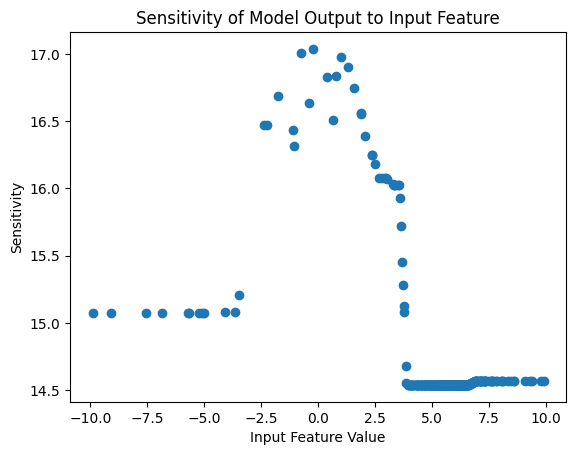

In [379]:
plt.plot(studied_space, -sensitivities, 'o')
plt.xlabel("Input Feature Value")
plt.ylabel("Sensitivity")
plt.title("Sensitivity of Model Output to Input Feature")
plt.show()



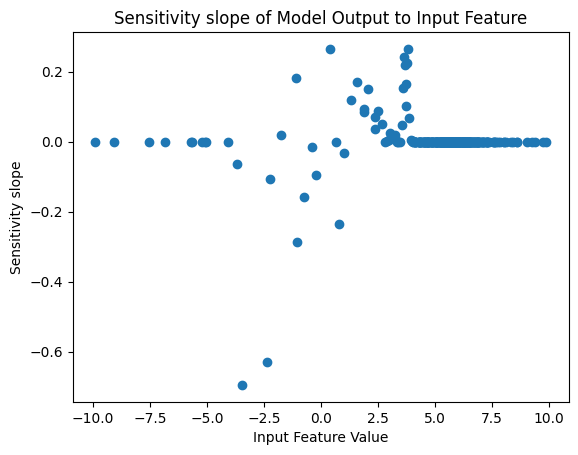

In [386]:
plt.plot(studied_space, np.gradient(sensitivities), 'o')
plt.xlabel("Input Feature Value")
plt.ylabel("Sensitivity slope")
plt.title("Sensitivity slope of Model Output to Input Feature")
plt.show()


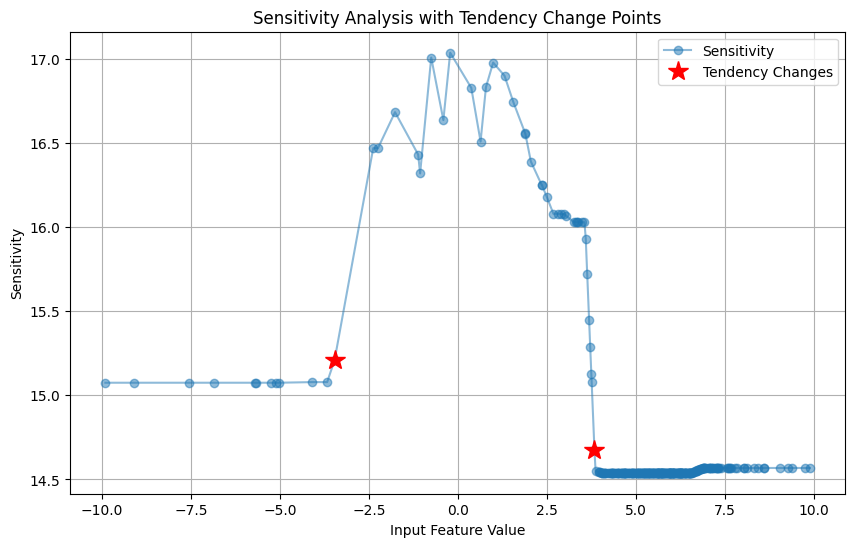

In [383]:
sensitivity_threshold = np.gradient(sensitivities,2).std()

sensitivity_gradient = np.gradient(sensitivities,2)

low_sensitivity_mask = np.abs(sensitivity_gradient) < sensitivity_threshold
high_sensitivity_regions = studied_space[~low_sensitivity_mask]

valid_interval = np.array([high_sensitivity_regions.min(), high_sensitivity_regions.max()])

# Plot original sensitivity curve
plt.figure(figsize=(10, 6))
plt.plot(studied_space, -sensitivities, 'o-', alpha=0.5, label='Sensitivity')

# Highlight tendency change points
plt.plot(valid_interval, -sensitivities[np.where(np.isin(studied_space, valid_interval))], 'r*', 
         markersize=15, label='Tendency Changes')

plt.xlabel("Input Feature Value")
plt.ylabel("Sensitivity") 
plt.title("Sensitivity Analysis with Tendency Change Points")
plt.legend()
plt.grid(True)
plt.show()

In [384]:
valid_interval


array([-3.46270365,  3.83387627])

In [385]:
np.array([X.min(), X.max()])

array([-3.24126734,  3.85273149])